In [1]:
# invoke some initial libraries that we want as part of this setup
import matplotlib.pylab as plt
import numpy as np
import MDAnalysis as mdanal
import pyemma.coordinates as coor
#import anca

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


In [15]:
import platform
print (platform.python_version())

3.6.5


In [2]:
def getCoordinates(pdbFileName, trjFileName):
    u = mdanal.Universe(pdbFileName, trjFileName, permissive=False)
    frames = []
    Ca = u.select_atoms('name CA')    
    for ts in u.trajectory[::]:
        frames.append(Ca.positions.T);
    return np.array(frames);

In [3]:
trajfile = '/Users/7ap/Documents/anca/codes/bpti_ca_1ms_dt10ns_aligned.xtc'
topfile = '/Users/7ap/Documents/anca/codes/bpti_ca.pdb'

In [4]:
coords = getCoordinates(topfile, trajfile)

/anaconda3/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:152: RuntimeWarning: invalid value encountered in float_scalars
  angle = np.arccos(np.dot(a, b) / (norm(a) * norm(b)))


In [5]:
plt.style.use('ggplot')

In [6]:
print (coords.shape)

(412497, 3, 58)


In [7]:
import KabschAlign

In [8]:
#from anca.align import IterativeMeansAlign
import IterativeMeansAlign

iterAlign = IterativeMeansAlign.IterativeMeansAlign();
[itr, avgCoordsAll, eRMSDAll, newCoordsAll] = iterAlign.iterativeMeans(coords, 0.001, 5);

In [9]:
coordsAll = np.reshape(newCoordsAll, (len(newCoordsAll), 3*58)).T; 
avgCoordsAll = np.mean(coordsAll, 1); #print avgCoords;
tmpAll = np.reshape(np.tile(avgCoordsAll, 412497), (412497,3*58)).T; 
caDevsMDall = coordsAll - tmpAll;
print (caDevsMDall.shape);

(174, 412497)


In [10]:
Nc = coords.shape[0]; # number of conformers in the simulation
dim = coords.shape[1]; # number of dimensions - usually 3
Na = coords.shape[2]; # number of atoms in the selection

In [11]:
import getSmoothingWeights, getInstantaneousKurtosis;

In [12]:
#from anca.events import getSmoothingWeights, getInstantaneousKurtosis, kurtosisTestPlot, pickEventConformations;

wt = getSmoothingWeights.getSmoothingWeights(dt = 25, windowsize=500, halflife=5000);
[c, kvals, kZscore, kpvalue] = getInstantaneousKurtosis.getInstantaneousKurtosis(caDevsMDall=caDevsMDall,wt=wt, dt=25, windowsize=500, halflife=5000, perRes=False, smooth=True)

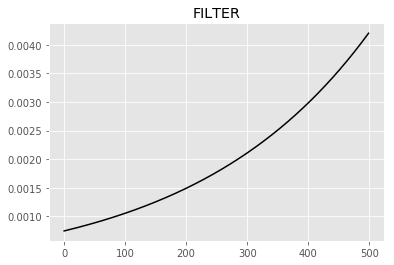

In [13]:
plt.title('FILTER')    
plt.plot(wt, 'k-');
plt.show();

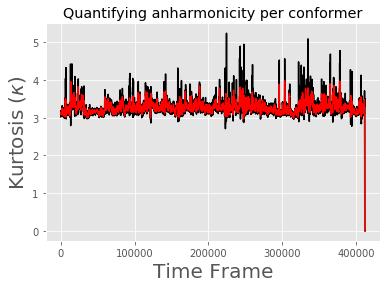

In [14]:
import matplotlib.ticker as ticker

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(100000))

plt.title('Quantifying anharmonicity per conformer') 
plt.plot(kvals, 'k-'); 
plt.plot(c, 'r-');
plt.xlabel('Time Frame', fontsize=20);
plt.ylabel('Kurtosis ($\kappa$)', fontsize=20);
plt.show();

In [16]:
# Hover plot to display Z-score and pvalue for a conformer in the trajectory space specified by conformerSize parameter
import mpld3

conformerSize = 1000;

fig, ax = plt.subplots(figsize=(10,10))
ax.grid(color='white', linestyle='solid')
x = range(conformerSize);
lines = ax.plot(x,kvals[0:conformerSize], marker='o')
plt.title('Kurtosis Test: Zscore, pvalue calculation on per-conformer basis')
plt.xlabel('Time Frame', fontsize=20);
plt.ylabel('Kurtosis', fontsize=20);
plt.grid(True);
plt.legend();

labels = ['Zscore: {}, pvalue: {}'.format(i,j) for i,j in zip(kZscore[0:conformerSize],kpvalue[0:conformerSize])];
mpld3.plugins.connect(fig, mpld3.plugins.PointClickableHTMLTooltip(lines[0],labels=labels))
mpld3.display()

No handles with labels found to put in legend.
/anaconda3/lib/python3.6/site-packages/mpld3/mplexporter/exporter.py:179: UserWarning: Legend element <matplotlib.offsetbox.HPacker object at 0x1a587a0c18> not impemented
  warnings.warn("Legend element %s not impemented" % child)


In [17]:
# function to pick significant event occurence in the trajectory dataset
import MDAnalysis.coordinates.DCD as writer
import MDAnalysis

def pickEventConformations(kvals, kurt_cutoff, topfile, trajfile, select_atoms):
    event = []
    u_event = MDAnalysis.Universe(topfile, trajfile)
    if select_atoms == 'CA':
        atoms = 'name CA'
    elif select_atoms == 'all atoms':
        atoms = 'all'
    selatoms = u_event.select_atoms(atoms);
    
    list_event = (np.where(kvals>kurt_cutoff)[0])
    with writer.DCDWriter("Events"+".dcd", selatoms.n_atoms) as W:
        for ts in u_event.trajectory[np.asarray(list_event)]:
            W.write(selatoms);
    event.append(W)

In [18]:
pickEventConformations(kvals=kvals,kurt_cutoff=4.5, topfile=topfile, trajfile=trajfile, select_atoms = 'CA');

/anaconda3/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:152: RuntimeWarning: invalid value encountered in float_scalars
  angle = np.arccos(np.dot(a, b) / (norm(a) * norm(b)))
